# Hotel Database
## Assignment

Design, populate, and query a database for a hotel reservation system with the following business rules:

1. The hotel has a number of rooms of two types: Deluxe and Suite
2. For every night, some rooms are made available for reservation for a specific price.
3. A guest can make a reservation for an avavilable room for one night. The reservation must include credit card payment info. At most one reservation can be made per night per room.
4. A guest can check into a room that has been reserved. An attempt to check in without a reservation will generate an error.
5. A guest can check out only after checking in. An attempt to check out multiple times or check out without checking in will generate an error.

Your Python code should provide the following:

1. A section to create the tables. The design must be in 3rd normal form following the conventions discussed in class and enforcing the business rules above.

2. Provide code to populate rooms and room availability with prices.

3. The function `reserve_room(room, date, guest_name, credit_card)` to make a reservation. A script that populates at least 300 reservations (e.g. use `faker`)

4. The functions `checkin(room, date)` and `checkout(room, date)` to check guests in and out. Write a script that invokes `checkin` and `checkout` for a buncha guests.  Demonstrate that that the functions enforces the rules of the business.

5. Write a query to list all guests who have stayed in a given room in 2021.

6. Write a query to list all dates on which a specific guest stayed at the hotel.



# Define the database

In [1]:
import datajoint as dj
schema = dj.Schema('hotel')

[2023-10-24 22:24:39,860][INFO]: Connecting root@fakeservices.datajoint.io:3306
[2023-10-24 22:24:39,868][INFO]: Connected root@fakeservices.datajoint.io:3306


In [2]:
@schema
class Room(dj.Manual):
    definition = """
    room : int
    --- 
    room_type : enum('Deluxe', 'Suite')
    """

In [3]:
@schema
class RoomAvailable(dj.Manual):
    definition = """
    -> Room
    date : date 
    ---
    price : decimal(6, 2)
    """

In [4]:
@schema
class Guest(dj.Manual):
    definition = """
    guest_id : int unsigned
    --- 
    guest_name : varchar(60)
    index(guest_name)
    """

In [5]:
@schema
class Reservation(dj.Manual):
    definition = """
    -> RoomAvailable
    ---
    -> Guest
    credit_card : varchar(80)
    """

In [6]:
@schema
class CheckIn(dj.Manual):
    definition = """
    -> Reservation
    """

In [7]:
@schema
class CheckOut(dj.Manual):
    definition = """
    -> CheckIn
    """

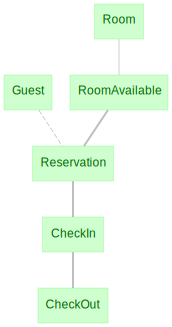

In [8]:
dj.Diagram(schema)

# Populate Room Availability

In [9]:
import faker
import random
import datetime
import tqdm
fake = faker.Faker()

In [10]:
# populate rooms
Room.insert((i, "Deluxe" if i%2 else "Suite") for i in range(80))

In [11]:
# Populate Room availability: 45 days starting on start_date
start_date = datetime.date(2021, 10, 1)
days = 45

for day in tqdm.tqdm(range(days)):
    price = random.randint(40, 350) 
    RoomAvailable.insert(
        dict(key, 
             date=start_date + datetime.timedelta(days=day), 
             price=price) for key in Room.fetch('KEY'))
    

100%|██████████| 45/45 [00:02<00:00, 21.22it/s]


# Functions 

In [12]:
class HotelException(Exception): pass
class RoomUnavailable(HotelException): pass
class RoomAlreadyReserved(HotelException): pass
class AlreadyChecked(HotelException): pass
class NoReservation(HotelException): pass
class NotCheckedIn(HotelException): pass

In [13]:
def reserve_room(room, date, guest_name, credit_card):
    # lookup guest by name
    keys = (Guest & {'guest_name': guest_name}).fetch('KEY')
    
    if keys:
        # if multiple found, use the first, for example
        key = keys[0]  
    else:
        # if not registered before, create a new guest id
        key = dict(guest_id=random.randint(0, 2**32-1))
        Guest.insert1(dict(key, guest_name=guest_name))
    
    try:
        Reservation.insert1(
            dict(key, room=room, date=date, credit_card=credit_card))
    except dj.errors.DuplicateError:
        raise RoomAlreadyReserved(room, date.isoformat()) from None
    except dj.errors.IntegrityError:
        raise RoomUnavailable(room, date.isoformat()) from None

In [14]:
def check_in(room, date):
    try:
        CheckIn.insert1(dict(room=room, date=date))
    except dj.errors.DuplicateError:
        raise AlreadyChecked(room, date.isoformat()) from None
    except dj.errors.IntegrityError:
        raise NoReservation(room, date.isoformat()) from None

In [15]:
def check_out(room, date):
    try:
        CheckOut.insert1(dict(room=room, date=date))
    except dj.errors.DuplicateError:
        raise AlreadyChecked(room, date.isoformat()) from None
    except dj.errors.IntegrityError:
        raise NotCheckedIn(room, date.isoformat()) from None

# Operations

In [16]:
# make a bunch of random reservations

number_of_guests = 100
max_nights = 20

for i in tqdm.tqdm(range(number_of_guests)):
    guest = fake.name()
    credit_card=' '.join((fake.credit_card_number(), 
                          fake.credit_card_expire(), 
                          fake.credit_card_security_code()))
    
    for j in range(random.randint(1, max_nights)):
        date =  fake.date_between_dates(start_date, start_date+datetime.timedelta(days=45))
        room = random.randint(0, 80)
        try:
            reserve_room(room, date, guest, credit_card)
        except HotelException as e:
            print(repr(e))
            
# show successful reservations
Reservation()

  1%|          | 1/100 [00:00<00:36,  2.72it/s]

RoomUnavailable(80, '2021-10-14')


  5%|▌         | 5/100 [00:01<00:37,  2.54it/s]

RoomUnavailable(80, '2021-11-07')


  7%|▋         | 7/100 [00:02<00:25,  3.60it/s]

RoomUnavailable(80, '2021-10-31')


 12%|█▏        | 12/100 [00:03<00:32,  2.71it/s]

RoomAlreadyReserved(50, '2021-10-17')


 16%|█▌        | 16/100 [00:04<00:22,  3.81it/s]

RoomUnavailable(80, '2021-10-21')
RoomAlreadyReserved(27, '2021-10-07')


 18%|█▊        | 18/100 [00:05<00:31,  2.63it/s]

RoomUnavailable(80, '2021-10-30')


 20%|██        | 20/100 [00:06<00:33,  2.42it/s]

RoomAlreadyReserved(16, '2021-10-30')
RoomAlreadyReserved(41, '2021-11-10')


 23%|██▎       | 23/100 [00:07<00:29,  2.64it/s]

RoomAlreadyReserved(20, '2021-11-10')


 25%|██▌       | 25/100 [00:08<00:27,  2.76it/s]

RoomAlreadyReserved(28, '2021-11-05')
RoomAlreadyReserved(71, '2021-10-13')
RoomAlreadyReserved(4, '2021-10-03')


 26%|██▌       | 26/100 [00:08<00:23,  3.09it/s]

RoomAlreadyReserved(23, '2021-10-12')


 27%|██▋       | 27/100 [00:09<00:26,  2.73it/s]

RoomAlreadyReserved(19, '2021-10-16')
RoomAlreadyReserved(19, '2021-10-16')


 32%|███▏      | 32/100 [00:10<00:23,  2.93it/s]

RoomUnavailable(80, '2021-10-30')


 35%|███▌      | 35/100 [00:12<00:26,  2.49it/s]

RoomAlreadyReserved(25, '2021-11-03')
RoomAlreadyReserved(45, '2021-10-18')


 36%|███▌      | 36/100 [00:12<00:25,  2.53it/s]

RoomAlreadyReserved(78, '2021-11-08')


 39%|███▉      | 39/100 [00:13<00:18,  3.29it/s]

RoomAlreadyReserved(20, '2021-10-24')
RoomAlreadyReserved(46, '2021-11-13')


 40%|████      | 40/100 [00:13<00:17,  3.36it/s]

RoomAlreadyReserved(4, '2021-10-30')
RoomAlreadyReserved(23, '2021-10-10')


 44%|████▍     | 44/100 [00:14<00:14,  3.92it/s]

RoomAlreadyReserved(72, '2021-10-16')
RoomAlreadyReserved(44, '2021-10-20')
RoomAlreadyReserved(41, '2021-11-01')
RoomAlreadyReserved(7, '2021-11-05')


 46%|████▌     | 46/100 [00:15<00:15,  3.44it/s]

RoomAlreadyReserved(75, '2021-10-12')
RoomAlreadyReserved(53, '2021-10-31')


 48%|████▊     | 48/100 [00:15<00:10,  4.83it/s]

RoomAlreadyReserved(8, '2021-10-21')


 50%|█████     | 50/100 [00:15<00:12,  4.14it/s]

RoomUnavailable(80, '2021-10-06')
RoomAlreadyReserved(52, '2021-10-09')
RoomAlreadyReserved(44, '2021-10-06')
RoomAlreadyReserved(39, '2021-10-15')


 52%|█████▏    | 52/100 [00:16<00:18,  2.61it/s]

RoomAlreadyReserved(25, '2021-10-09')
RoomAlreadyReserved(58, '2021-10-26')
RoomAlreadyReserved(11, '2021-10-28')


 53%|█████▎    | 53/100 [00:17<00:18,  2.52it/s]

RoomAlreadyReserved(14, '2021-10-04')
RoomAlreadyReserved(49, '2021-10-18')
RoomAlreadyReserved(71, '2021-10-13')


 54%|█████▍    | 54/100 [00:17<00:18,  2.43it/s]

RoomAlreadyReserved(27, '2021-10-18')
RoomAlreadyReserved(40, '2021-10-14')
RoomAlreadyReserved(47, '2021-10-14')
RoomUnavailable(80, '2021-10-11')


 56%|█████▌    | 56/100 [00:18<00:14,  3.04it/s]

RoomAlreadyReserved(31, '2021-11-02')


 57%|█████▋    | 57/100 [00:18<00:12,  3.44it/s]

RoomAlreadyReserved(44, '2021-10-21')
RoomAlreadyReserved(24, '2021-10-23')
RoomAlreadyReserved(75, '2021-10-21')


 58%|█████▊    | 58/100 [00:18<00:12,  3.27it/s]

RoomAlreadyReserved(42, '2021-10-21')
RoomAlreadyReserved(67, '2021-10-19')


 60%|██████    | 60/100 [00:19<00:09,  4.08it/s]

RoomAlreadyReserved(40, '2021-10-01')
RoomAlreadyReserved(73, '2021-11-10')


 62%|██████▏   | 62/100 [00:19<00:10,  3.77it/s]

RoomAlreadyReserved(58, '2021-10-23')


 65%|██████▌   | 65/100 [00:20<00:08,  4.06it/s]

RoomAlreadyReserved(22, '2021-10-19')
RoomAlreadyReserved(59, '2021-10-19')
RoomAlreadyReserved(11, '2021-10-24')
RoomAlreadyReserved(26, '2021-10-21')
RoomAlreadyReserved(4, '2021-10-20')


 67%|██████▋   | 67/100 [00:20<00:06,  4.83it/s]

RoomAlreadyReserved(30, '2021-10-09')
RoomAlreadyReserved(0, '2021-10-09')
RoomUnavailable(80, '2021-10-13')


 69%|██████▉   | 69/100 [00:21<00:06,  4.48it/s]

RoomAlreadyReserved(21, '2021-10-02')
RoomAlreadyReserved(51, '2021-11-09')
RoomAlreadyReserved(25, '2021-11-04')
RoomAlreadyReserved(11, '2021-11-05')
RoomAlreadyReserved(43, '2021-11-07')


 71%|███████   | 71/100 [00:21<00:07,  3.86it/s]

RoomAlreadyReserved(62, '2021-10-01')
RoomAlreadyReserved(28, '2021-10-31')
RoomAlreadyReserved(18, '2021-11-02')
RoomAlreadyReserved(5, '2021-10-01')
RoomAlreadyReserved(64, '2021-10-14')
RoomAlreadyReserved(30, '2021-11-13')
RoomAlreadyReserved(17, '2021-11-11')


 73%|███████▎  | 73/100 [00:22<00:07,  3.82it/s]

RoomAlreadyReserved(4, '2021-10-09')
RoomAlreadyReserved(48, '2021-11-05')
RoomAlreadyReserved(39, '2021-10-15')


 76%|███████▌  | 76/100 [00:22<00:04,  5.01it/s]

RoomAlreadyReserved(27, '2021-10-09')
RoomAlreadyReserved(29, '2021-10-22')


 77%|███████▋  | 77/100 [00:23<00:05,  4.56it/s]

RoomAlreadyReserved(40, '2021-10-26')


 78%|███████▊  | 78/100 [00:23<00:05,  4.24it/s]

RoomAlreadyReserved(9, '2021-10-07')
RoomAlreadyReserved(71, '2021-10-18')
RoomAlreadyReserved(57, '2021-10-22')


 79%|███████▉  | 79/100 [00:23<00:05,  4.10it/s]

RoomAlreadyReserved(45, '2021-11-06')
RoomAlreadyReserved(46, '2021-11-08')
RoomAlreadyReserved(67, '2021-10-12')
RoomAlreadyReserved(51, '2021-11-12')


 81%|████████  | 81/100 [00:24<00:04,  3.86it/s]

RoomAlreadyReserved(31, '2021-10-18')
RoomAlreadyReserved(55, '2021-10-26')
RoomAlreadyReserved(58, '2021-10-21')
RoomAlreadyReserved(14, '2021-10-01')
RoomUnavailable(80, '2021-11-13')
RoomAlreadyReserved(29, '2021-10-29')


 83%|████████▎ | 83/100 [00:24<00:03,  4.81it/s]

RoomAlreadyReserved(18, '2021-11-02')
RoomAlreadyReserved(40, '2021-10-07')
RoomAlreadyReserved(61, '2021-11-05')
RoomAlreadyReserved(0, '2021-11-07')


 86%|████████▌ | 86/100 [00:25<00:03,  4.17it/s]

RoomAlreadyReserved(38, '2021-11-04')
RoomAlreadyReserved(56, '2021-10-30')
RoomAlreadyReserved(48, '2021-10-03')


 87%|████████▋ | 87/100 [00:25<00:03,  3.88it/s]

RoomAlreadyReserved(74, '2021-10-09')
RoomAlreadyReserved(29, '2021-10-19')
RoomAlreadyReserved(50, '2021-10-07')
RoomAlreadyReserved(58, '2021-10-15')


 89%|████████▉ | 89/100 [00:26<00:02,  3.78it/s]

RoomAlreadyReserved(77, '2021-10-17')
RoomAlreadyReserved(27, '2021-10-01')


 91%|█████████ | 91/100 [00:26<00:02,  3.83it/s]

RoomAlreadyReserved(47, '2021-11-02')
RoomAlreadyReserved(52, '2021-10-18')


 92%|█████████▏| 92/100 [00:27<00:02,  3.42it/s]

RoomAlreadyReserved(38, '2021-10-03')
RoomAlreadyReserved(26, '2021-11-10')
RoomAlreadyReserved(14, '2021-11-11')


 93%|█████████▎| 93/100 [00:27<00:01,  3.62it/s]

RoomAlreadyReserved(74, '2021-10-09')
RoomAlreadyReserved(70, '2021-10-16')
RoomAlreadyReserved(67, '2021-10-11')
RoomAlreadyReserved(58, '2021-10-09')
RoomAlreadyReserved(15, '2021-11-11')
RoomAlreadyReserved(3, '2021-10-17')
RoomUnavailable(80, '2021-10-27')


 95%|█████████▌| 95/100 [00:27<00:01,  3.77it/s]

RoomAlreadyReserved(63, '2021-11-14')
RoomAlreadyReserved(46, '2021-10-10')
RoomAlreadyReserved(27, '2021-10-19')
RoomAlreadyReserved(30, '2021-10-28')
RoomAlreadyReserved(2, '2021-11-04')


 96%|█████████▌| 96/100 [00:28<00:01,  3.12it/s]

RoomAlreadyReserved(10, '2021-10-27')
RoomAlreadyReserved(5, '2021-10-12')
RoomAlreadyReserved(62, '2021-10-26')
RoomAlreadyReserved(44, '2021-10-08')


 97%|█████████▋| 97/100 [00:28<00:00,  3.24it/s]

RoomAlreadyReserved(27, '2021-10-09')
RoomAlreadyReserved(43, '2021-11-04')


 98%|█████████▊| 98/100 [00:28<00:00,  3.74it/s]

RoomAlreadyReserved(10, '2021-10-06')
RoomAlreadyReserved(54, '2021-10-08')
RoomAlreadyReserved(41, '2021-10-22')
RoomAlreadyReserved(67, '2021-10-19')


100%|██████████| 100/100 [00:29<00:00,  3.39it/s]

RoomAlreadyReserved(36, '2021-11-03')


room,date,guest_id,credit_card
0,2021-10-05,1689116194,4963501761746225 08/27 246
0,2021-10-06,2398806164,6011977965828059 09/29 351
0,2021-10-09,1101032312,4982755741654 09/26 256
0,2021-10-28,572555526,675926497545 05/30 826
0,2021-11-01,572555526,675926497545 05/30 826
0,2021-11-07,1101032312,4982755741654 09/26 256
0,2021-11-12,3722081738,4616430089622 03/32 788
1,2021-10-01,1347060425,5438160252295707 11/28 697
1,2021-10-02,1474515654,4029504389232637911 01/32 591
1,2021-10-08,1575600856,4129092192215320 08/25 652


In [17]:
Guest()

guest_id,guest_name
3342266079,Aaron Bradley
3320236962,Alison Burke
1060653779,Amanda Kim
1347060425,Anthony Jackson
3664806043,Anthony Santana
3594289303,Barbara Mcintyre
171664340,Caitlin Little
4223113568,Carol Patel
3592385568,Charles Neal
2453762139,Christina Meyer


In [18]:
# Try check in
check_in(2, datetime.date(2021, 10, 2))

NoReservation: (2, '2021-10-02')

In [19]:
# checkin a bunch of people
checkins = random.sample(Reservation().fetch('KEY'), k=int(0.9*len(Reservation())))
for r in tqdm.tqdm(checkins):
    try: 
        check_in(**r)
    except AlreadyChecked as e:
        print(repr(e))


100%|██████████| 777/777 [00:22<00:00, 33.91it/s]


In [ ]:
CheckIn()

In [ ]:
# Try duplicate checkin
check_in(**checkins[0])

In [ ]:
# Try checkout

check_out(2, datetime.date(2021, 10, 2))

In [ ]:
# checkout a bunch of people
checkouts = random.sample(CheckIn().fetch('KEY'), k=int(0.9*len(CheckIn())))
for r in tqdm.tqdm(checkouts):
    try:
        check_out(**r)
    except AlreadyChecked as e:
        print repr(e)

In [ ]:
# try duplicate checkout

check_out(**checkouts[0])

# Queries 

## Query 1: List all guests who have stayed in room 1

In [ ]:
Guest & (Reservation & (CheckIn & 'room=1'))

In [ ]:
Guest & (Reservation * CheckIn & 'room=1')

In [ ]:
_.make_sql()

## Query 2: List all nights when a guest stayed at a hotel

In [ ]:
# pick a guest
guest = random.choice(Guest().fetch('KEY'))

In [ ]:
guest

In [ ]:
(Reservation * CheckIn & guest).proj()